In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
cur_path = "/content/drive/MyDrive/bigdata_project"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/bigdata_project


In [ ]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=7d71b321f9d2a538556aa1ee40cf341fdf3d26d3fcc48238f56b305ac2d560dd
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

In [2]:
from pyspark import SparkContext
import numpy as np
from pyspark.sql import SparkSession
from __future__ import print_function
from functools import wraps
import pyspark as spark
from pyspark import SparkConf
import time
from operator import add
import os 
from subprocess import STDOUT, check_call, check_output
from numpy.random import permutation as pm
from numpy.random import seed
import numpy as np 
import time 
from collections import Counter
import pickle
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

## Download one-hot encoding results from the previous step

In [5]:
with open(cur_path + '/ref_sparse_15', "rb") as fp:   # Unpickling
   ref_sparse_15 = pickle.load(fp)
with open(cur_path + '/read_sparse_15', "rb") as fp:   # Unpickling
   read_sparse_15 = pickle.load(fp)
with open(cur_path + '/ref_sparse_20', "rb") as fp:   # Unpickling
   ref_sparse_20 = pickle.load(fp)
with open(cur_path + '/read_sparse_20', "rb") as fp:   # Unpickling
   read_sparse_20 = pickle.load(fp)

## Minhash: kmer size = 15 and permutation number = 1000

In [6]:
def minHash(num_pm,sparse,all_line_num):
  sigs = np.zeros((num_pm,len(sparse)))
  for i in range(num_pm):
    seed(seed = i)
    permutated = list(pm(all_line_num))
    for t in range(len(sparse)):
      sigs[i,t] =  min([permutated[z] for z in sparse[t][1].indices])
  return sigs

In [7]:
# find the number of kmer
num_kmer = ref_sparse_15[0][1].size
all_line_num = [i for i in range(num_kmer)]

In [13]:
start = time.time()
# read signature
read_sigs_15 = minHash(1000,read_sparse_15,all_line_num)
# ref signature
ref_sigs_15 = minHash(1000,ref_sparse_15,all_line_num)
print('Without applying parallel in hash function, time cost:' , time.time()-start,'seconds')

Without applying parallel in hash function, time cost: 95.46437668800354 seconds


## Parallel Minhash

In [10]:
def per_permuation(sparse,i):
  seed(seed=i) 
  permutated = list(pm(all_line_num))
  result = []
  for i in range(len(sparse)):
    result.append(min([permutated[z] for z in sparse[i][1].indices]))
  return result

In [11]:
start = time.time()
# read
pool = mp.Pool(mp.cpu_count()) 
read_sig_p = np.zeros((1000,len(read_sparse_15)))
for i in range(1000):
  read_sig_p[i,:] = pool.apply(per_permuation, args=(read_sparse_15,i))
pool.close()

# ref
pool = mp.Pool(mp.cpu_count()) 
ref_sig_p = np.zeros((1000,len(ref_sparse_15)))
for i in range(1000):
  ref_sig_p[i,:] = pool.apply(per_permuation, args=(ref_sparse_15,i))
pool.close()
print('With applying parallel in hash function, time cost:' , time.time()-start,'seconds')

With applying parallel in hash function, time cost: 241.76488947868347 seconds


In [17]:
#check parallel results
print('Check if equals to 2000*1000 = 2000000:', np.cumsum(read_sig_p == read_sigs_15)[-1])
print('Check if equals to 500*1000 = 500000:', np.cumsum(ref_sig_p == ref_sigs_15)[-1])

Check if equals to 2000*1000 = 2000000: 2000000
Check if equals to 500*1000 = 500000: 500000


#### It took around 241 seconds to apply parallelism in the hash function, but it only took around 95 seconds without using the parallel function. This contradicts our expectation that, with the help of parallelism, the running time can decrease.

## Jacard distance

In [ ]:
def cal_jacard_res(A, B):
  c = Counter(A) & Counter(B)
  return sum(c.values()) / len(set(A).union(B))

In [ ]:
def jacard_result(read, ref, read_sigs, ref_sigs):
  result = np.zeros((len(read),len(ref)))
  for i in range(len(read)):
    read_infor = list(read_sigs[:,i])
    for t in range(len(ref)):
      ref_infor = list(ref_sigs[:,t])
      result[i,t] = cal_jacard_res(read_infor,ref_infor)
  return result

In [ ]:
jr_15_1000 = jacard_result(read_sparse_15,ref_sparse_15,read_sigs_15,ref_sigs_15)

## Analyze results

In [ ]:
def convert_result_to_df(jr, read):
  result = np.zeros((len(read),3))
  for i in range(len(read)):
    result[i,0] = int(i)
    all_jacard = list(jr[i,:])
    max_jacard = max(all_jacard)
    result[i,1] = all_jacard.index(max_jacard)
    result[i,2] = max(all_jacard)
  result_pd = pd.DataFrame(result)
  result_pd.columns = ['readname','bin','sim']
  result_pd['readname'] = result_pd['readname'].astype(int)
  result_pd['bin'] = result_pd['bin'].astype(int)
  result_process = result_pd
  result_process['start'] = result_process['bin'].apply(lambda x: 20000000+ x*100)
  result_process['end'] = result_process['start'].apply(lambda x: x+ 100) 
  return result_process

In [ ]:
df_15_1000 = convert_result_to_df(jr_15_1000,read_sparse_15)
df_15_1000.head(5)

,readname,bin,sim,start,end
0,0,0,0.435094,20000000,20000100
1,1,0,0.386285,20000000,20000100
2,2,0,0.455696,20000000,20000100
3,3,0,0.830971,20000000,20000100
4,4,0,0.752892,20000000,20000100


In [ ]:
# concate with the benchmark
benchmark = pd.read_csv('/content/drive/MyDrive/bigdata_project/read_position_benchmark.csv')
pred_benchmark = pd.concat([df_15_1000,benchmark[['reference_start','reference_end']]],axis =1)
pred_benchmark.head(10)

,readname,bin,sim,start,end,reference_start,reference_end
0,0,0,0.435094,20000000,20000100,19999958,20000058
1,1,0,0.386285,20000000,20000100,19999966,20000066
2,2,0,0.455696,20000000,20000100,19999974,20000074
3,3,0,0.830971,20000000,20000100,19999995,20000095
4,4,0,0.752892,20000000,20000100,20000001,20000101
5,5,0,0.715897,20000000,20000100,20000010,20000110
6,6,0,0.506530,20000000,20000100,20000037,20000137
7,7,0,0.354756,20000000,20000100,20000040,20000140
8,8,0,0.372498,20000000,20000100,20000056,20000156
9,9,1,0.412478,20000100,20000200,20000060,20000160


### Pearson correlation

In [ ]:
pc_s_15_1000 = scipy.stats.pearsonr(pred_benchmark['start'].tolist(), pred_benchmark['reference_start'].tolist())
print('The pearson correlation of predicted start and reference start is: '+ str(pc_s_15_1000[0]))

The pearson correlation of predicted start and reference start is: 0.9974774275367242


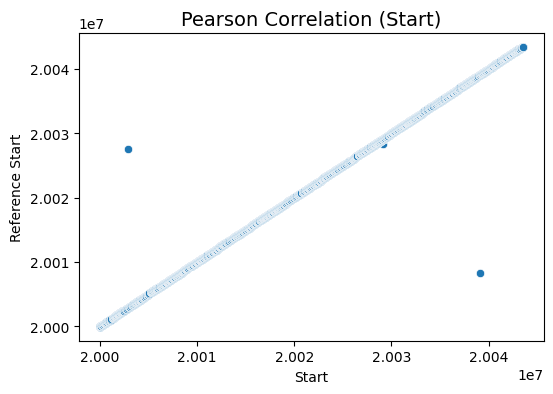

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
sns.scatterplot(ax = ax, x="start", y="reference_start", data=pred_benchmark);
ax.set_xlabel('Start')
ax.set_ylabel('Reference Start')
ax.set_title('Pearson Correlation (Start)',fontsize=14)
plt.show()

In [ ]:
pc_e_15_1000 = scipy.stats.pearsonr(pred_benchmark['end'].tolist(), pred_benchmark['reference_end'].tolist())
print('The pearson correlation of predicted start and reference start is: '+ str(pc_e_15_1000[0]))

The pearson correlation of predicted start and reference start is: 0.9974774274063333


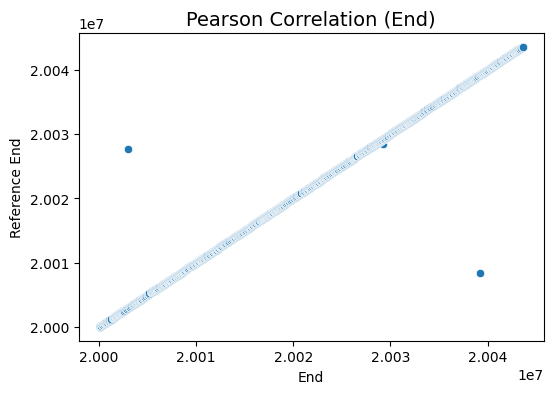

In [ ]:
fig, ax = plt.subplots(figsize = ( 6 , 4 ))
sns.scatterplot(x="end", y="reference_end", data=pred_benchmark);
ax.set_xlabel('End')
ax.set_ylabel('Reference End')
ax.set_title('Pearson Correlation (End)',fontsize=14)
plt.show()

### Mean Squared Error

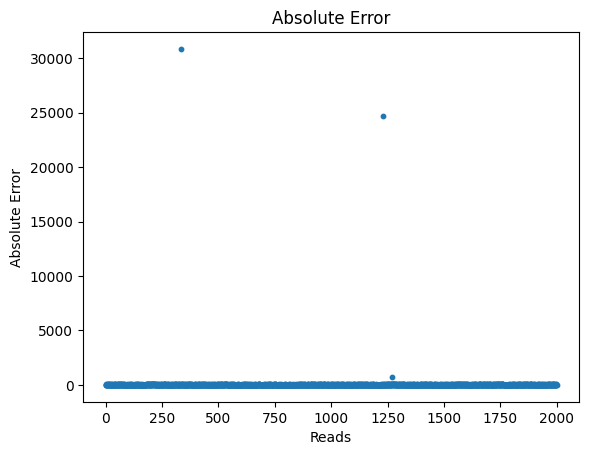

In [ ]:
# absolute of start 
ab_s_15_1000 = [abs(i-z) for i,z in zip(pred_benchmark['start'].tolist(),pred_benchmark['reference_start'].tolist())]
plt.scatter([i for i in range(2000)], ab_s_15_1000, s = 10)
plt.xlabel('Reads')
plt.ylabel('Absolute Error')
plt.title('Absolute Error')
plt.show()

#### There are three outliers, which will significantly influence the MSE. Thus, drop them

In [ ]:
mse_s_15_1000 = [(i-z)**2 for i,z in zip(pred_benchmark['start'].tolist(),pred_benchmark['reference_start'].tolist())]
# without outliers. MSE < 10000 means that there is an overlap between predicted and reference results
mse_s_wo_15_1000 = [i for i in mse_s_15_1000 if i < 10000]
print('The MSE of start without outliers is: ' + str(np.mean(mse_s_wo_15_1000)))
mse_e_15_1000 = [(i-z)**2 for i,z in zip(pred_benchmark['end'].tolist(),pred_benchmark['reference_end'].tolist())]
# without outliers. MSE < 10000 means that there is an overlap between predicted and reference results
mse_e_wo_15_1000 = [i for i in mse_e_15_1000 if i < 10000]
print('The MSE of end without outliers is: ' + str(np.mean(mse_e_wo_15_1000)))

The MSE of start without outliers is: 895.6024036054081
The MSE of end without outliers is: 895.9659489233851


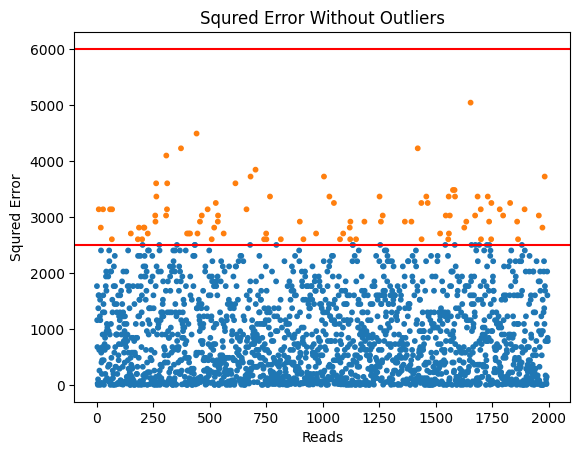

In [ ]:
# further exploration
colors = ["#ff7f0e" if i > 2500 else "#1f77b4" for i in mse_s_wo_15_1000]
plt.scatter([i for i in range(len(mse_s_wo_15_1000))], mse_s_wo_15_1000, s = 10, c = colors)
plt.xlabel('Reads')
plt.ylabel('Squred Error')
plt.axhline(y = 2500, color = 'r', linestyle = '-')
plt.axhline(y = 6000, color = 'r', linestyle = '-')
plt.title('Squred Error Without Outliers')
plt.show()

#### MSE result quality analysis
#### Define
best prediction: squared error <= 2500  \
second optimal: squared error > 2500 and squared error < 10000  \
outlier: squared error > 10000 

In [ ]:
def prediction_quality_visua(num_best, num_so, num_ot):
  outlier = ['outlier'] * num_ot
  best = ['best']* num_best
  second = ['second optimal']* num_so
  outlier.extend(best)
  outlier.extend(second)

  # Set the figure size
  plt.figure(figsize=(6, 4))

  # Create the histogram
  counts, bins, patches = plt.hist(outlier, bins=50, color='#607c8e')

  # Add labels and title
  
  plt.xlabel('Quality', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)

  # Remove top and right spines
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  # Adjust tick label size
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Add text annotations
  for i in range(len(counts)):
      count = counts[i]
      bin = bins[i]
      if count > 0:
          plt.text(bin + (bins[i+1] - bin) / 2, count + 5, str(int(count)),
                  ha='center', va='bottom', fontsize=12)

  plt.show()

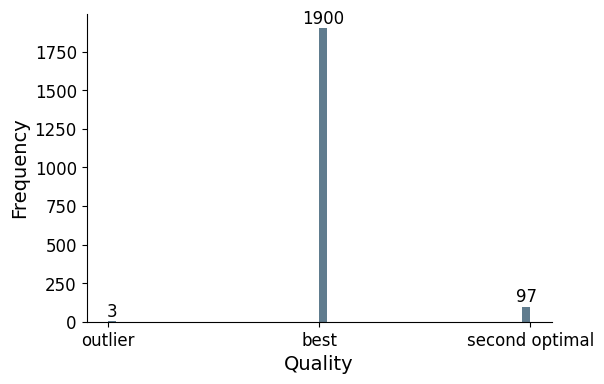

In [ ]:
num_best = len([i for i in mse_s_15_1000 if i <= 2500])
num_so = len([i for i in mse_s_15_1000 if i <= 10000 and i > 2500])
num_ot = len([i for i in mse_s_15_1000 if i > 10000])
prediction_quality_visua(num_best, num_so, num_ot)

## Bonus Part: try different kmer size and permutation number. 
## Kmer size: 15, 20
## Number of permutation: 500, 1000, 2000

In [ ]:
def analyze_result(jr,read):
  df = convert_result_to_df(jr,read)
  pred_benchmark = pd.concat([df,benchmark[['reference_start','reference_end']]],axis =1)
  # pearson correlation
  pc_s = scipy.stats.pearsonr(pred_benchmark['start'].tolist(), pred_benchmark['reference_start'].tolist())
  print('The pearson correlation of predicted start and reference start is: '+ str(pc_s[0]))
  fig, ax = plt.subplots(figsize = (6,4))
  sns.scatterplot(ax = ax, x="start", y="reference_start", data=pred_benchmark);
  ax.set_xlabel('Start')
  ax.set_ylabel('Reference Start')
  ax.set_title('Pearson Correlation (Start)',fontsize=14)
  plt.show()

  pc_e = scipy.stats.pearsonr(pred_benchmark['end'].tolist(), pred_benchmark['reference_end'].tolist())
  print('The pearson correlation of predicted end and reference end is: '+ str(pc_e[0]))
  fig, ax = plt.subplots(figsize = (6,4))
  sns.scatterplot(ax = ax, x="end", y="reference_end", data=pred_benchmark);
  ax.set_xlabel('End')
  ax.set_ylabel('Reference End')
  ax.set_title('Pearson Correlation (End)',fontsize=14)
  plt.show()

  # MSE
  mse_s = [(i-z)**2 for i,z in zip(pred_benchmark['start'].tolist(),pred_benchmark['reference_start'].tolist())]
  # without outliers. MSE < 10000 means that there is an overlap between predicted and reference results
  mse_s_wo = [i for i in mse_s if i < 10000]
  print('The MSE of start without outliers is: ' + str(np.mean(mse_s_wo)))
  mse_e = [(i-z)**2 for i,z in zip(pred_benchmark['end'].tolist(),pred_benchmark['reference_end'].tolist())]
  # without outliers. MSE < 10000 means that there is an overlap between predicted and reference results
  mse_e_wo = [i for i in mse_e if i < 10000]
  print('The MSE of end without outliers is: ' + str(np.mean(mse_e_wo)))

  # prediction quality analysis
  num_best = len([i for i in mse_s if i <= 2500])
  num_so = len([i for i in mse_s if i <= 10000 and i > 2500])
  num_ot = len([i for i in mse_s if i > 10000])
  prediction_quality_visua(num_best, num_so, num_ot)

  return pc_s[0], num_ot/2000, num_best/2000

#### permutation number: 500, kmer size: 15

In [ ]:
# read signature
read_sigs_15_500 = minHash(500,read_sparse_15,all_line_num)
# ref signatures 
ref_sigs_15_500 = minHash(500,ref_sparse_15,all_line_num)

In [ ]:
jr_15_500 = jacard_result(read_sparse_15,ref_sparse_15,read_sigs_15_500,ref_sigs_15_500)

The pearson correlation of predicted start and reference start is: 0.9999848307211923


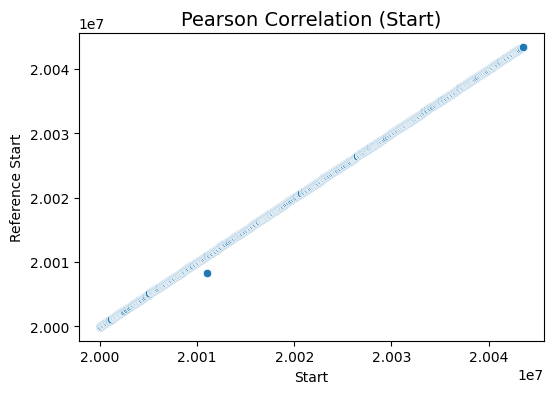

The pearson correlation of predicted end and reference end is: 0.9999848296846157


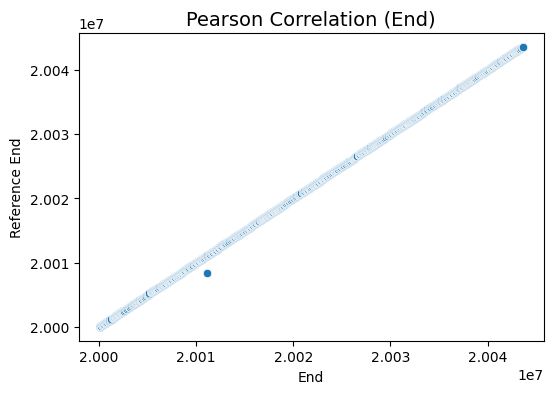

The MSE of start without outliers is: 898.0530265132567
The MSE of end without outliers is: 898.416208104052


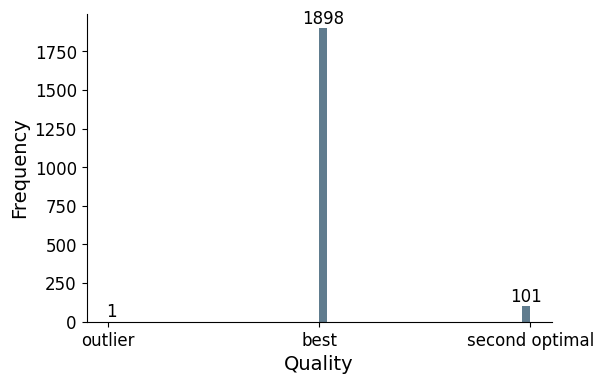

In [ ]:
pc_s_15_500, num_ot_p_15_500, num_best_p_15_500 = analyze_result(jr_15_500,read_sparse_15)

#### permutation number: 1000, kmer size: 15  (already exist)

The pearson correlation of predicted start and reference start is: 0.9974774275367242


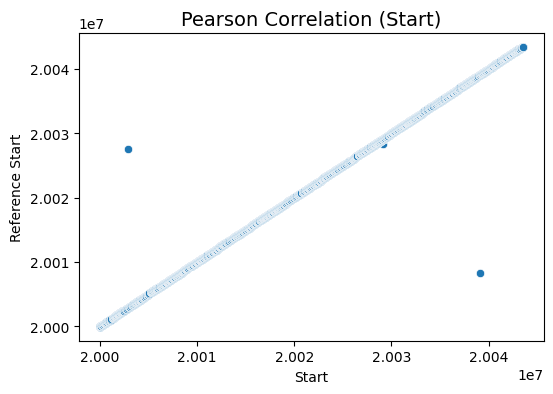

The pearson correlation of predicted end and reference end is: 0.9974774274063333


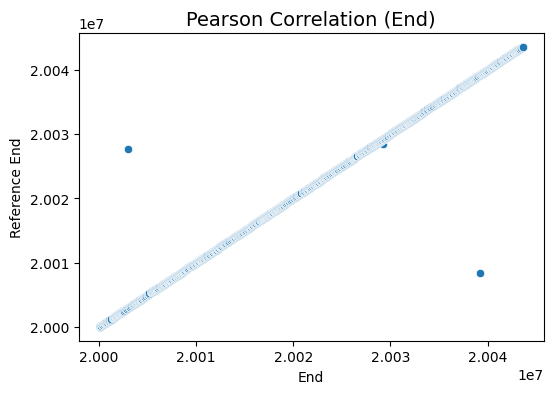

The MSE of start without outliers is: 895.6024036054081
The MSE of end without outliers is: 895.9659489233851


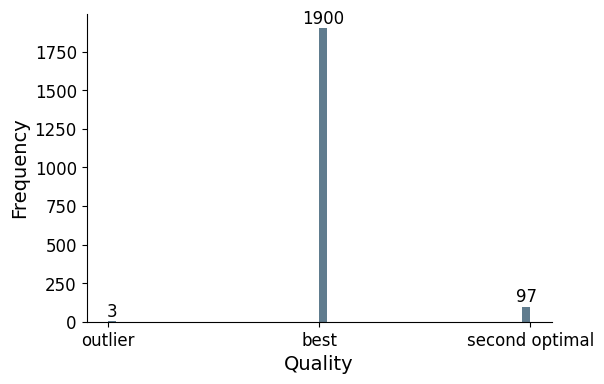

In [ ]:
pc_s_15_1000, num_ot_p_15_1000, num_best_p_15_1000 = analyze_result(jr_15_1000,read_sparse_15)

#### permutation number: 2000, kmer size: 15

In [ ]:
# read signature
read_sigs_15_2000 = minHash(2000,read_sparse_15,all_line_num)
# ref signatures 
ref_sigs_15_2000 = minHash(2000,ref_sparse_15,all_line_num)

In [ ]:
jr_15_2000 = jacard_result(read_sparse_15,ref_sparse_15,read_sigs_15_2000,ref_sigs_15_2000)

The pearson correlation of predicted start and reference start is: 0.998307304697086


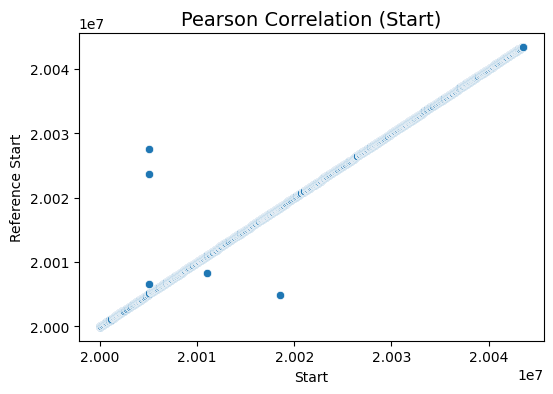

The pearson correlation of predicted end and reference end is: 0.9983073030454062


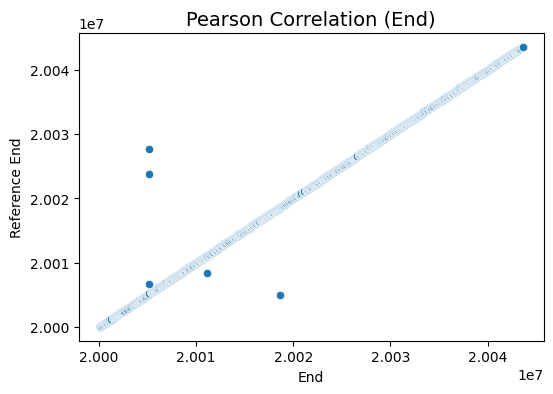

The MSE of start without outliers is: 901.2636591478697
The MSE of end without outliers is: 901.6275689223057


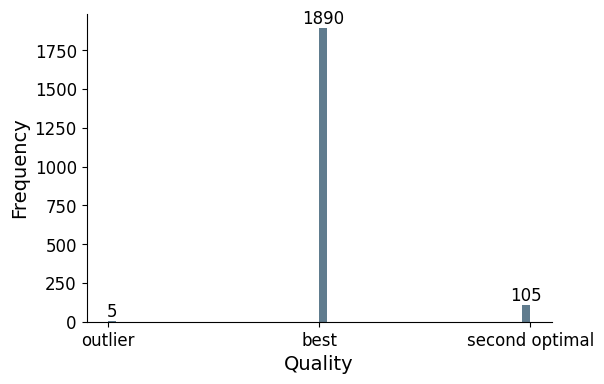

In [ ]:
pc_s_15_2000, num_ot_p_15_2000, num_best_p_15_2000 = analyze_result(jr_15_2000,read_sparse_15)

#### permutation number: 500, kmer size: 20





In [ ]:
# find the number of kmer
num_kmer_20 = ref_sparse_20[0][1].size
all_line_num_20 = [i for i in range(num_kmer_20)]
# read signature
read_sigs_20_500 = minHash(500,read_sparse_20,all_line_num_20)
# ref signatures 
ref_sigs_20_500 = minHash(500,ref_sparse_20,all_line_num_20)

In [ ]:
jr_20_500 = jacard_result(read_sparse_20,ref_sparse_20,read_sigs_20_500,ref_sigs_20_500)

The pearson correlation of predicted start and reference start is: 0.9893893161337418


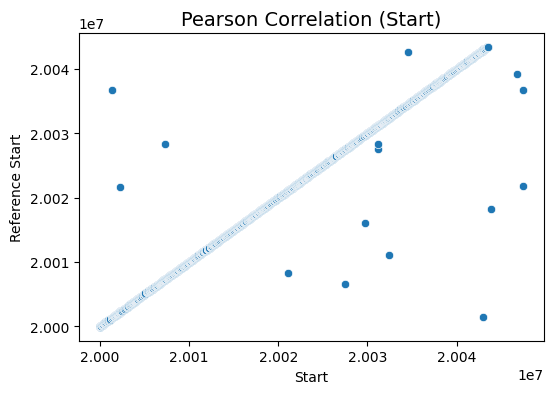

The pearson correlation of predicted end and reference end is: 0.9893893237065265


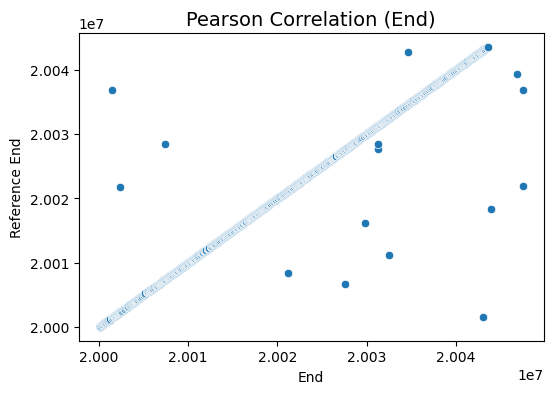

The MSE of start without outliers is: 923.6523929471033
The MSE of end without outliers is: 923.5143576826197


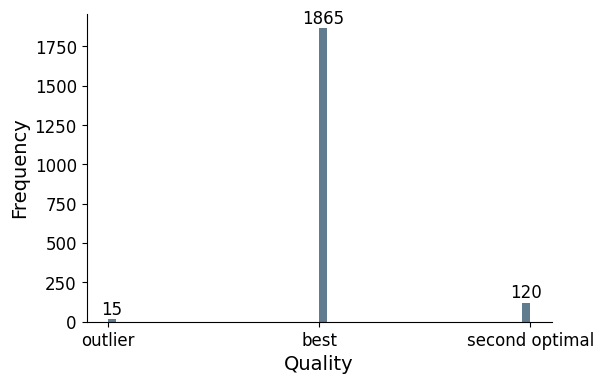

In [ ]:
pc_s_20_500, num_ot_p_20_500, num_best_p_20_500 = analyze_result(jr_20_500,read_sparse_20)

#### permutation number: 1000, kmer size: 20

In [ ]:
# read signature
read_sigs_20_1000 = minHash(1000,read_sparse_20,all_line_num_20)
# ref signatures 
ref_sigs_20_1000 = minHash(1000,ref_sparse_20,all_line_num_20)

In [ ]:
jr_20_1000 = jacard_result(read_sparse_20,ref_sparse_20,read_sigs_20_1000,ref_sigs_20_1000)

The pearson correlation of predicted start and reference start is: 0.9916029109957833


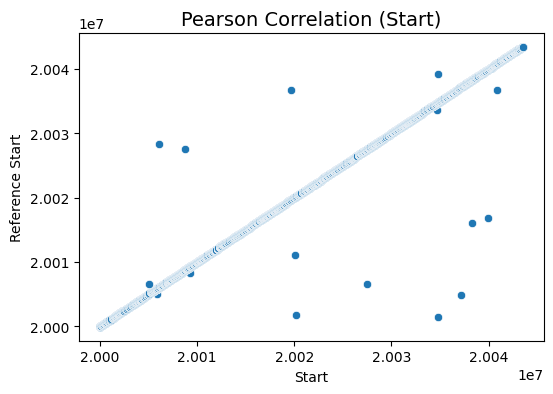

The pearson correlation of predicted end and reference end is: 0.9916029193214027


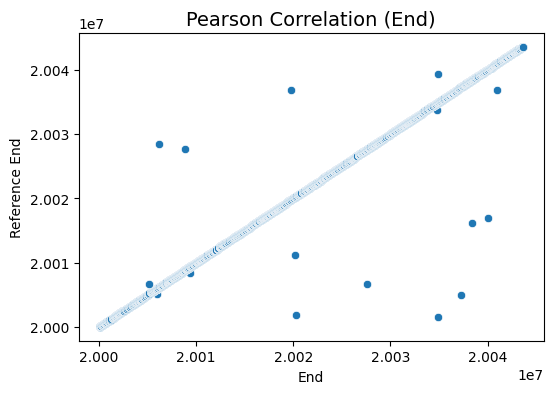

The MSE of start without outliers is: 910.9319556451613
The MSE of end without outliers is: 910.7938508064516


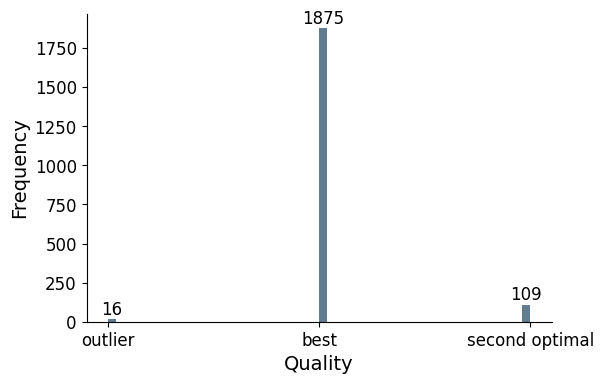

In [ ]:
pc_s_20_1000, num_ot_p_20_1000, num_best_p_20_1000 =  analyze_result(jr_20_1000,read_sparse_20)

#### permutation number: 2000, kmer size: 20

In [ ]:
# read signature
read_sigs_20_2000 = minHash(2000,read_sparse_20,all_line_num_20)
# ref signatures 
ref_sigs_20_2000 = minHash(2000,ref_sparse_20,all_line_num_20)

In [ ]:
jr_20_2000 = jacard_result(read_sparse_20,ref_sparse_20,read_sigs_20_2000,ref_sigs_20_2000)

The pearson correlation of predicted start and reference start is: 0.9703714528739439


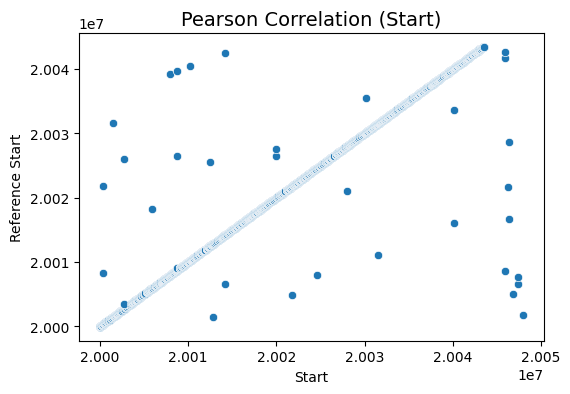

The pearson correlation of predicted end and reference end is: 0.9703714680492188


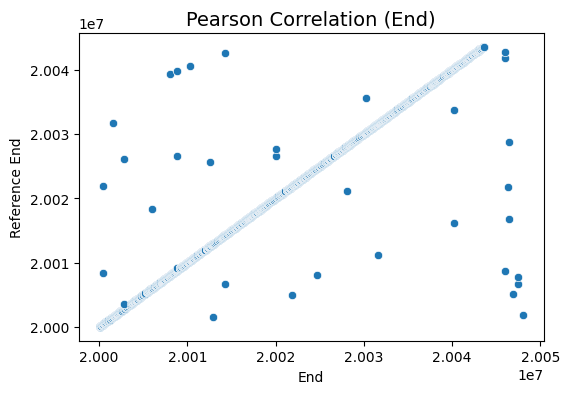

The MSE of start without outliers is: 903.8835198372329
The MSE of end without outliers is: 903.7441505595117


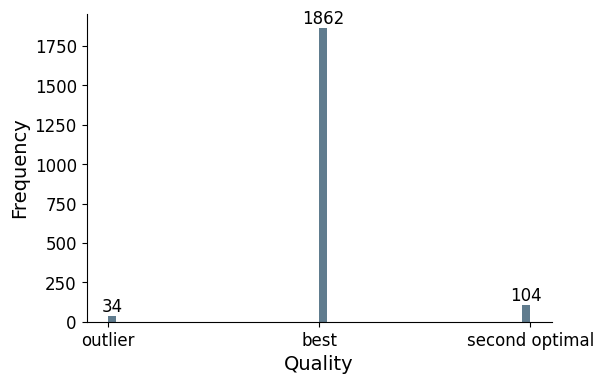

In [ ]:
pc_s_20_2000, num_ot_p_20_2000, num_best_p_20_2000 = analyze_result(jr_20_2000,read_sparse_20)

## Compare results from pearson correlation, best prediction percentage, and second optimal percentage. 
#### MSE is not a good metric when there are many outliers

In [ ]:
size_num_comb = np.array([[i,t] for i in [15,20] for t in [500,1000,2000]])
kmer_size_all = size_num_comb[:,0]
permu_num_all = size_num_comb[:,1]
pc = [pc_s_15_500,pc_s_15_1000,pc_s_15_2000,pc_s_20_500,pc_s_20_1000,pc_s_20_2000]
ot_p = [num_ot_p_15_500,num_ot_p_15_1000,num_ot_p_15_2000,num_ot_p_20_500,num_ot_p_20_1000,num_ot_p_20_2000]
best_p = [num_best_p_15_500,num_best_p_15_1000,num_best_p_15_2000,num_best_p_20_500,num_best_p_20_1000,num_best_p_20_2000]

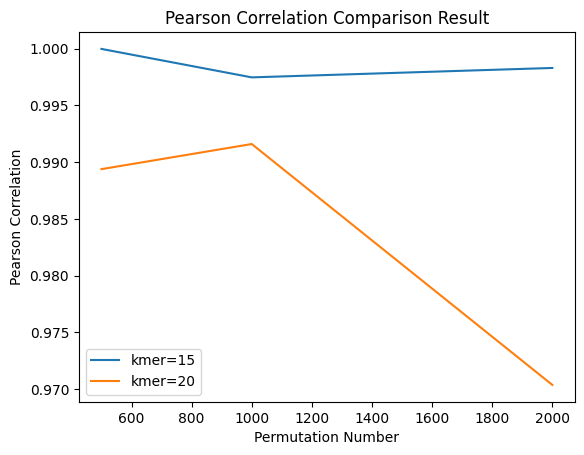

In [ ]:
mask_x15 = kmer_size_all == 15
mask_x20 = kmer_size_all == 20

# create line plot for X=15
plt.plot(permu_num_all[mask_x15], np.array(pc)[mask_x15], label='kmer=15')

# create line plot for X=20
plt.plot(permu_num_all[mask_x20], np.array(pc)[mask_x20], label='kmer=20')

# set axis labels
plt.xlabel('Permutation Number')
plt.ylabel('Pearson Correlation')

# set title
plt.title('Pearson Correlation Comparison Result')

# add legend
plt.legend()

# show plot
plt.show()

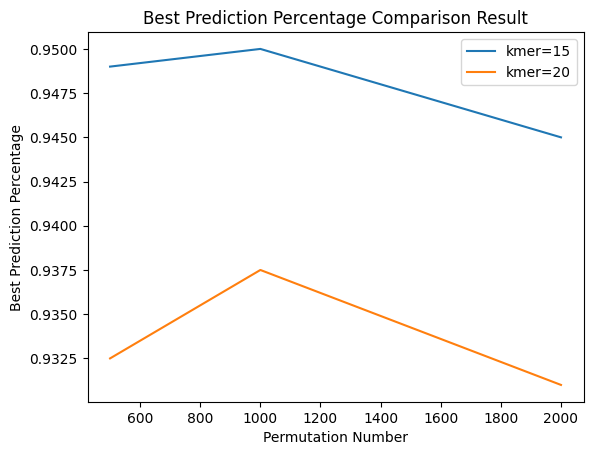

In [ ]:
# create line plot for X=15
plt.plot(permu_num_all[mask_x15], np.array(best_p)[mask_x15], label='kmer=15')

# create line plot for X=20
plt.plot(permu_num_all[mask_x20], np.array(best_p)[mask_x20], label='kmer=20')

# set axis labels
plt.xlabel('Permutation Number')
plt.ylabel('Best Prediction Percentage')

# set title
plt.title('Best Prediction Percentage Comparison Result')

# add legend
plt.legend()

# show plot
plt.show()

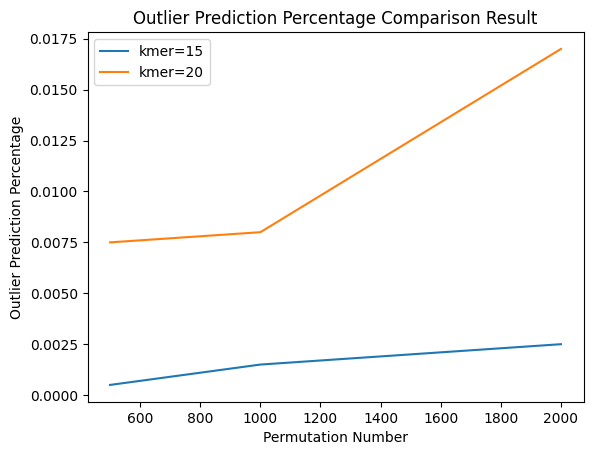

In [ ]:
# create line plot for X=15
plt.plot(permu_num_all[mask_x15], np.array(ot_p)[mask_x15], label='kmer=15')

# create line plot for X=20
plt.plot(permu_num_all[mask_x20], np.array(ot_p)[mask_x20], label='kmer=20')

# set axis labels
plt.xlabel('Permutation Number')
plt.ylabel('Outlier Prediction Percentage')

# set title
plt.title('Outlier Prediction Percentage Comparison Result')

# add legend
plt.legend()

# show plot
plt.show()